2018-07-06 20:16:26 - Start Program

> First Solve, disconnected reactive stages
------------------------------------------------------------------------------------------------------------
stages			T	Q	r_FT	Conversion	V_out	L_out	L_Prod		P_VLE
React-ive[1]		220.0	-43.2	0.2660	0.815		0.0000	0.0000	0.0064		20.000
React-ive[2]		220.0	-43.2	0.2660	0.815		0.0000	0.0000	0.0064		20.000
React-ive[3]		220.0	-43.2	0.2660	0.815		0.0000	0.0000	0.0064		20.000
React-ive[4]		220.0	-43.2	0.2660	0.815		0.0000	0.0000	0.0064		20.000
React-ive[5]		220.0	-43.2	0.2660	0.815		0.0000	0.0000	0.0064		20.000
React-ive[6]		220.0	-43.2	0.2660	0.815		0.0000	0.0000	0.0064		20.000
React-ive[7]		220.0	-43.2	0.2660	0.815		0.0000	0.0000	0.0064		20.000
React-ive[8]		220.0	-43.2	0.2660	0.815		0.0000	0.0000	0.0064		20.000
React-ive[9]		220.0	-43.2	0.2660	0.815		0.0000	0.0000	0.0064		20.000
React-ive[10]		220.0	-43.2	0.2660	0.815		0.0000	0.0000	0.0064		20.000
2018-07-06 20:16:38 - Elapsed time from last log
Elapsed time: 0

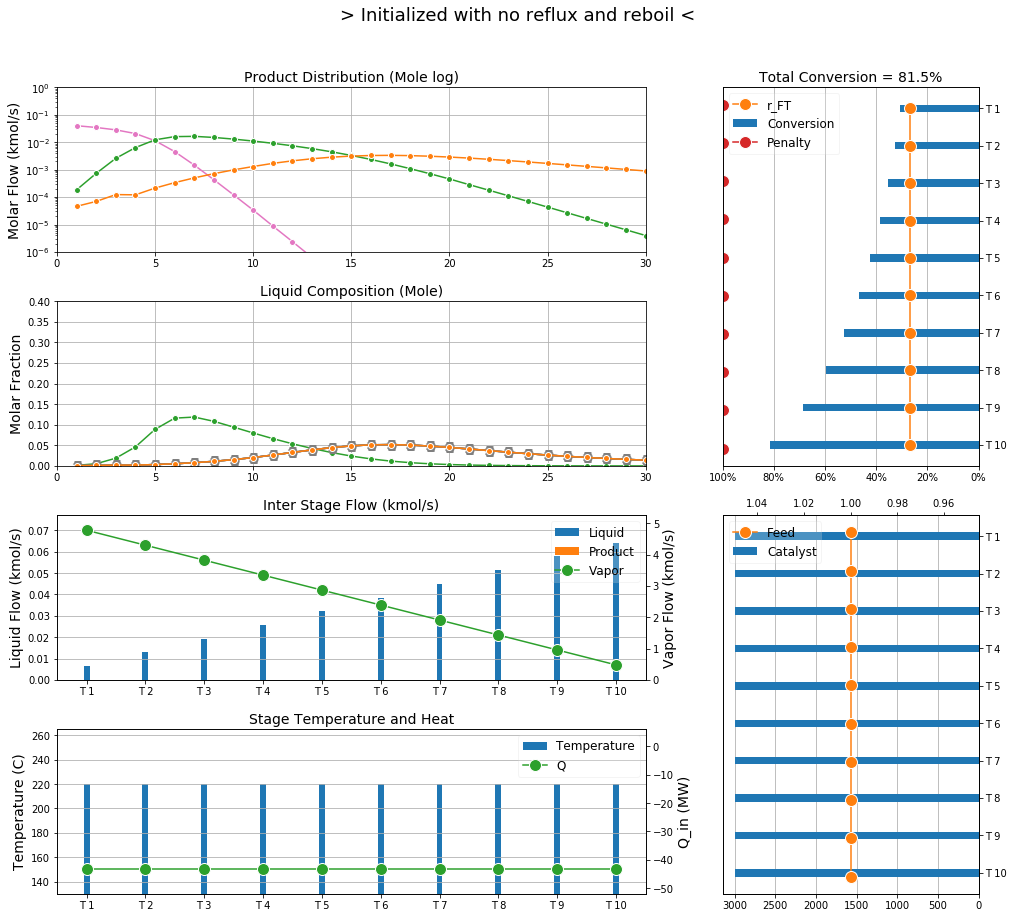


> Working on Reflux, PR ratio = 0.70
------------------------------------------------------------------------------------------------------------
Here comes the result:
------------------------------------------------------------------------------------------------------------
stages			T	Q				V_out	L_out	L_Prod		W
Condenser		30.00	-139.				2.5515	0.0582	0.1358		2.0884

stages			T	Q	r_FT	Conversion	V_out	L_out	L_Prod		P_VLE
React-ive[1]		220.0	-38.4	0.2651	0.305		4.8341	0.0116	0.0000		20.000
React-ive[2]		220.0	-43.1	0.2660	0.328		4.3017	0.0159	0.0000		20.000
React-ive[3]		220.0	-43.2	0.2660	0.355		3.8219	0.0218	0.0000		20.000
React-ive[4]		220.0	-43.2	0.2660	0.386		3.3438	0.0280	0.0000		20.000
React-ive[5]		220.0	-43.2	0.2660	0.423		2.8660	0.0344	0.0000		20.000
React-ive[6]		220.0	-43.2	0.2660	0.468		2.3882	0.0407	0.0000		20.000
React-ive[7]		220.0	-43.2	0.2660	0.524		1.9106	0.0471	0.0000		20.000
React-ive[8]		220.0	-43.2	0.2660	0.594		1.4329	0.0535	0.0000		20.000
React-ive[9]		220.0	

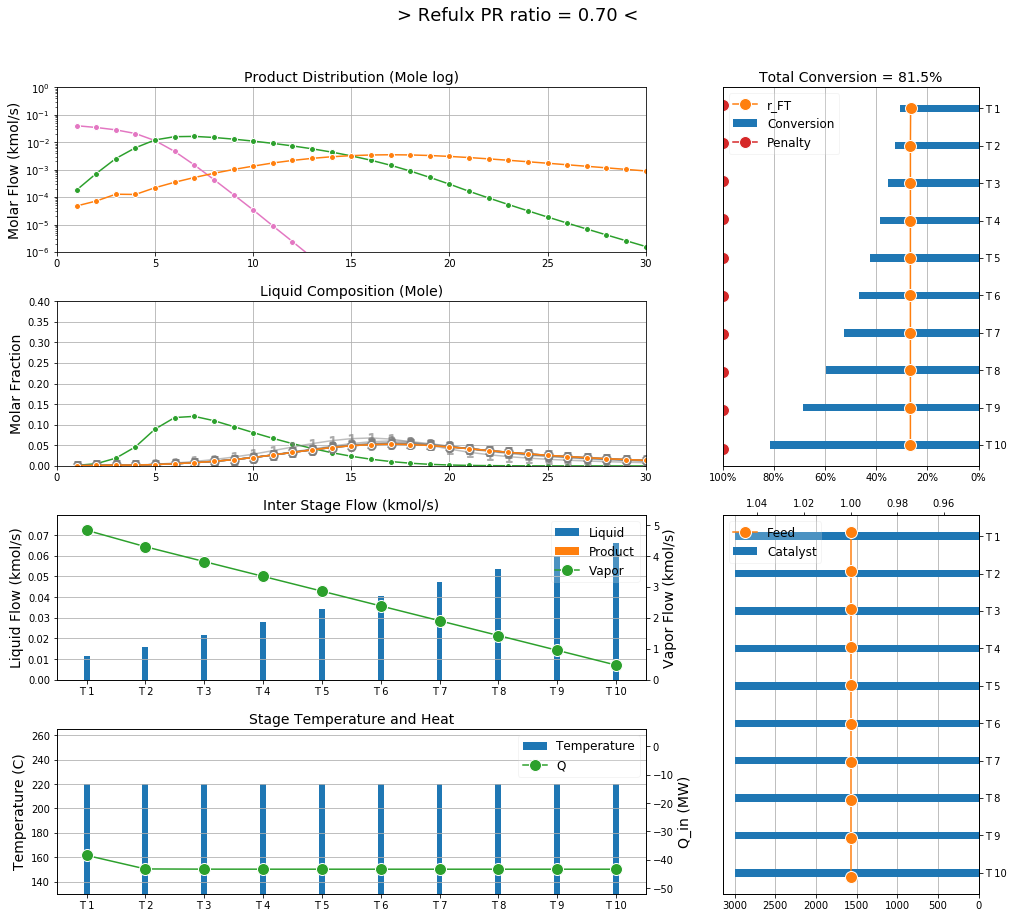


> Working on Reflux, PR ratio = 0.50
------------------------------------------------------------------------------------------------------------
Here comes the result:
------------------------------------------------------------------------------------------------------------
stages			T	Q				V_out	L_out	L_Prod		W
Condenser		30.00	-145.				2.5558	0.1328	0.1328		2.0869

stages			T	Q	r_FT	Conversion	V_out	L_out	L_Prod		P_VLE
React-ive[1]		220.0	-32.4	0.2641	0.303		4.9083	0.0218	0.0000		20.000
React-ive[2]		220.0	-42.9	0.2658	0.328		4.3096	0.0212	0.0000		20.000
React-ive[3]		220.0	-43.2	0.2660	0.355		3.8246	0.0259	0.0000		20.000
React-ive[4]		220.0	-43.2	0.2660	0.386		3.3452	0.0316	0.0000		20.000
React-ive[5]		220.0	-43.2	0.2660	0.423		2.8668	0.0376	0.0000		20.000
React-ive[6]		220.0	-43.2	0.2660	0.468		2.3888	0.0438	0.0000		20.000
React-ive[7]		220.0	-43.2	0.2660	0.524		1.9109	0.0500	0.0000		20.000
React-ive[8]		220.0	-43.2	0.2660	0.594		1.4331	0.0563	0.0000		20.000
React-ive[9]		220.0	

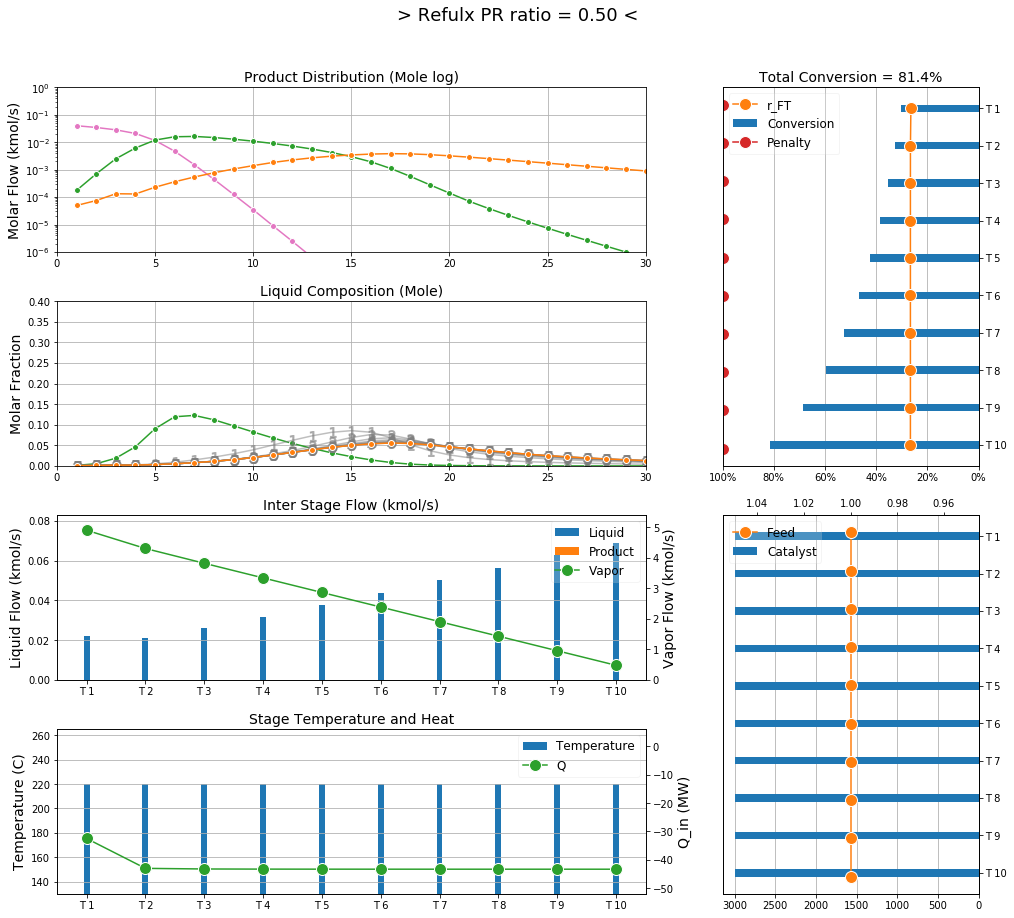


> Working on Reflux, PR ratio = 0.25
------------------------------------------------------------------------------------------------------------
Here comes the result:
------------------------------------------------------------------------------------------------------------
stages			T	Q				V_out	L_out	L_Prod		W
Condenser		30.00	-162.				2.5711	0.3687	0.1229		2.0814

stages			T	Q	r_FT	Conversion	V_out	L_out	L_Prod		P_VLE
React-ive[1]		220.0	-15.5	0.2610	0.299		5.1441	0.0831	0.0000		20.000
React-ive[2]		220.0	-41.8	0.2651	0.327		4.3649	0.0509	0.0000		20.000
React-ive[3]		220.0	-42.7	0.2657	0.354		3.8469	0.0454	0.0000		20.000
React-ive[4]		220.0	-43.0	0.2658	0.386		3.3569	0.0466	0.0000		20.000
React-ive[5]		220.0	-43.1	0.2659	0.423		2.8737	0.0502	0.0000		20.000
React-ive[6]		220.0	-43.2	0.2659	0.468		2.3930	0.0549	0.0000		20.000
React-ive[7]		220.0	-43.2	0.2659	0.523		1.9136	0.0602	0.0000		20.000
React-ive[8]		220.0	-43.2	0.2660	0.594		1.4348	0.0659	0.0000		20.000
React-ive[9]		220.0	

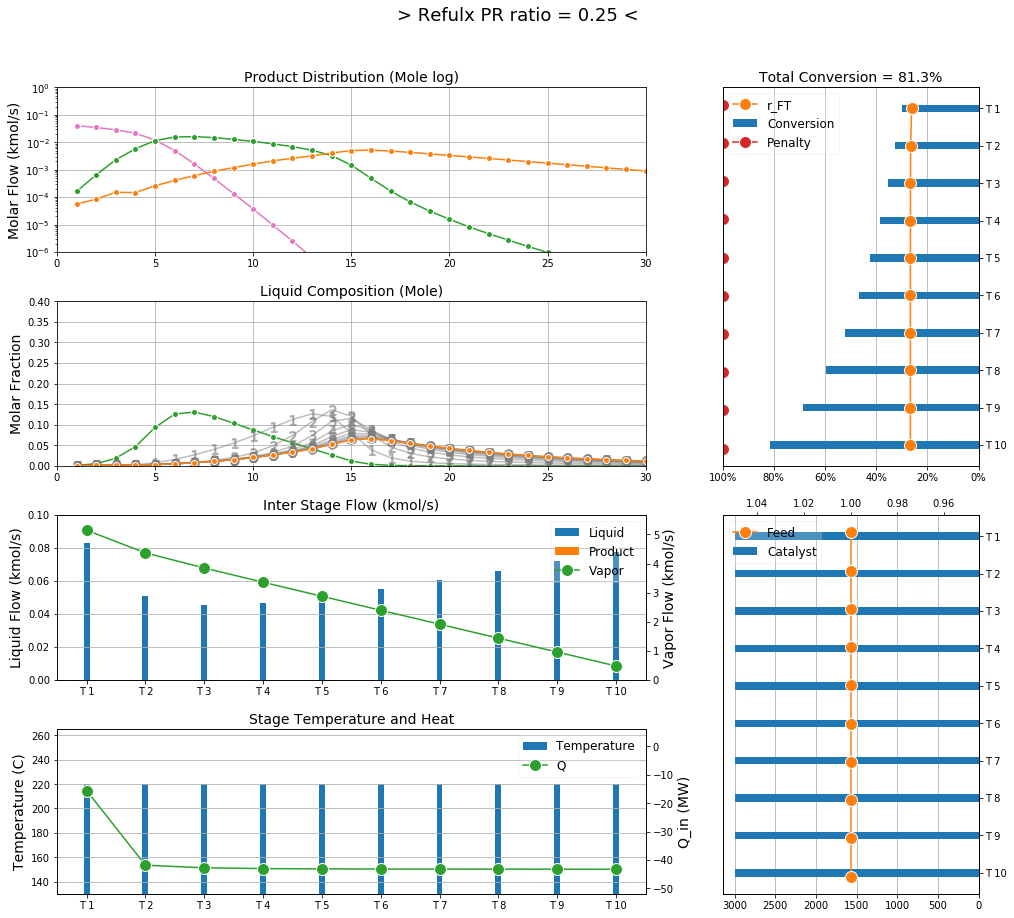


> Working on Reflux, PR ratio = 0.14
------------------------------------------------------------------------------------------------------------
Here comes the result:
------------------------------------------------------------------------------------------------------------
stages			T	Q				V_out	L_out	L_Prod		W
Condenser		30.00	-183.				2.5937	0.6689	0.1114		2.0731

stages			T	Q	r_FT	Conversion	V_out	L_out	L_Prod		P_VLE
React-ive[1]		220.0	3.370	0.2577	0.294		5.4473	0.2035	0.0000		20.000
React-ive[2]		220.0	-40.2	0.2638	0.324		4.4818	0.1160	0.0000		20.000
React-ive[3]		220.0	-41.8	0.2650	0.352		3.9060	0.0861	0.0000		20.000
React-ive[4]		220.0	-42.5	0.2654	0.384		3.3901	0.0743	0.0000		20.000
React-ive[5]		220.0	-42.8	0.2656	0.422		2.8931	0.0707	0.0000		20.000
React-ive[6]		220.0	-43.0	0.2658	0.467		2.4047	0.0711	0.0000		20.000
React-ive[7]		220.0	-43.1	0.2658	0.523		1.9207	0.0738	0.0000		20.000
React-ive[8]		220.0	-43.1	0.2659	0.594		1.4390	0.0777	0.0000		20.000
React-ive[9]		220.0	

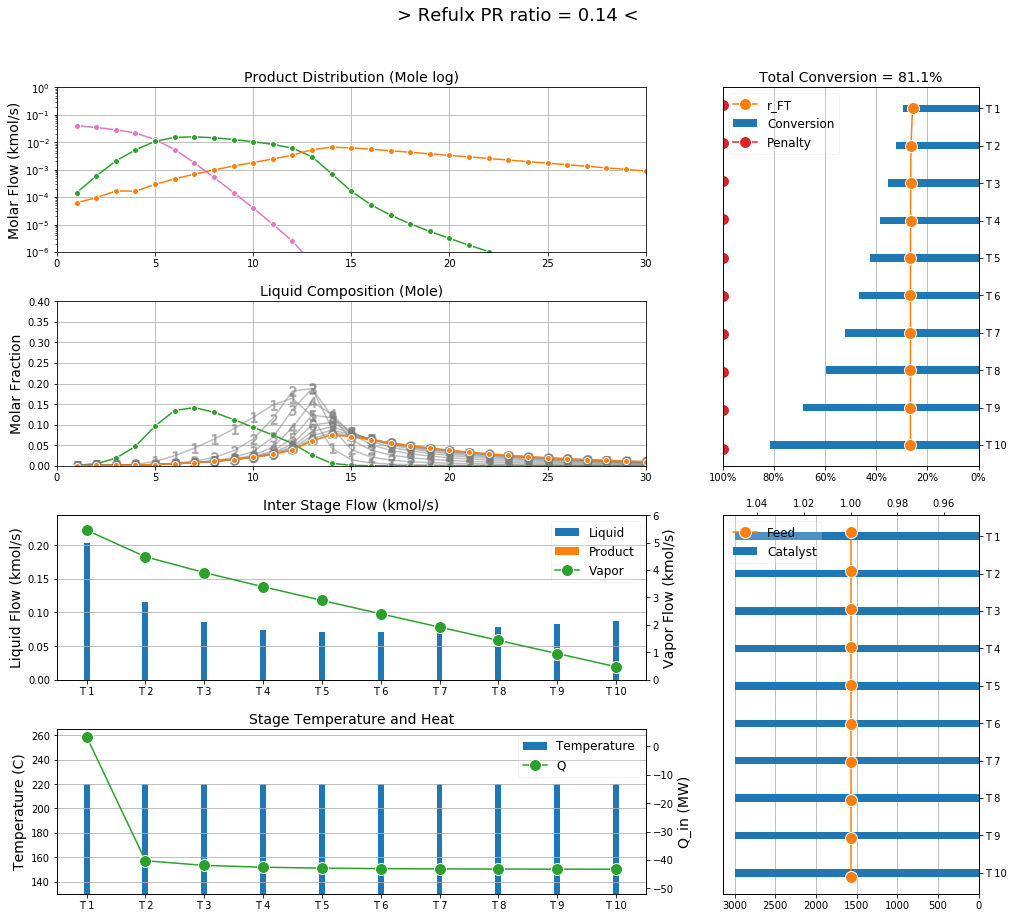


> Working on Reflux, PR ratio = 0.10
------------------------------------------------------------------------------------------------------------
Here comes the result:
------------------------------------------------------------------------------------------------------------
stages			T	Q				V_out	L_out	L_Prod		W
Condenser		30.00	-200.				2.6150	0.9273	0.1030		2.0653

stages			T	Q	r_FT	Conversion	V_out	L_out	L_Prod		P_VLE
React-ive[1]		220.0	18.62	0.2552	0.289		5.7107	0.3259	0.0000		20.000
React-ive[2]		220.0	-39.0	0.2625	0.321		4.6042	0.1887	0.0000		20.000
React-ive[3]		220.0	-41.0	0.2642	0.351		3.9761	0.1329	0.0000		20.000
React-ive[4]		220.0	-41.9	0.2649	0.383		3.4328	0.1052	0.0000		20.000
React-ive[5]		220.0	-42.4	0.2653	0.421		2.9189	0.0917	0.0000		20.000
React-ive[6]		220.0	-42.7	0.2655	0.466		2.4200	0.0863	0.0000		20.000
React-ive[7]		220.0	-42.9	0.2657	0.522		1.9297	0.0854	0.0000		20.000
React-ive[8]		220.0	-43.0	0.2658	0.593		1.4442	0.0871	0.0000		20.000
React-ive[9]		220.0	

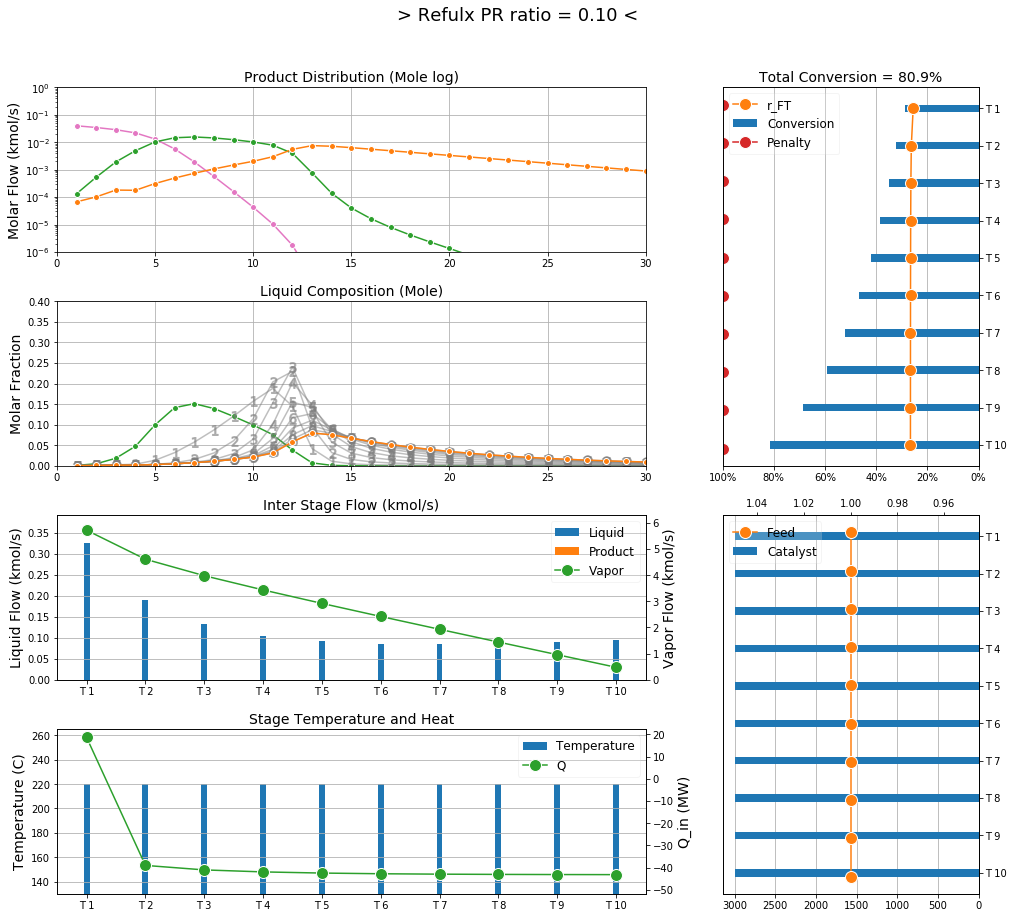


> Working on Reflux, PR ratio = 0.08
------------------------------------------------------------------------------------------------------------
Here comes the result:
------------------------------------------------------------------------------------------------------------
stages			T	Q				V_out	L_out	L_Prod		W
Condenser		30.00	-215.				2.6346	1.1575	0.0964		2.0580

stages			T	Q	r_FT	Conversion	V_out	L_out	L_Prod		P_VLE
React-ive[1]		220.0	31.75	0.2530	0.285		5.9467	0.4435	0.0000		20.000
React-ive[2]		220.0	-38.0	0.2612	0.319		4.7235	0.2615	0.0000		20.000
React-ive[3]		220.0	-40.3	0.2634	0.349		4.0483	0.1809	0.0000		20.000
React-ive[4]		220.0	-41.4	0.2644	0.381		3.4786	0.1367	0.0000		20.000
React-ive[5]		220.0	-42.0	0.2649	0.420		2.9472	0.1125	0.0000		20.000
React-ive[6]		220.0	-42.5	0.2653	0.465		2.4369	0.1004	0.0000		20.000
React-ive[7]		220.0	-42.8	0.2655	0.522		1.9394	0.0956	0.0000		20.000
React-ive[8]		220.0	-42.9	0.2657	0.593		1.4496	0.0948	0.0000		20.000
React-ive[9]		220.0	

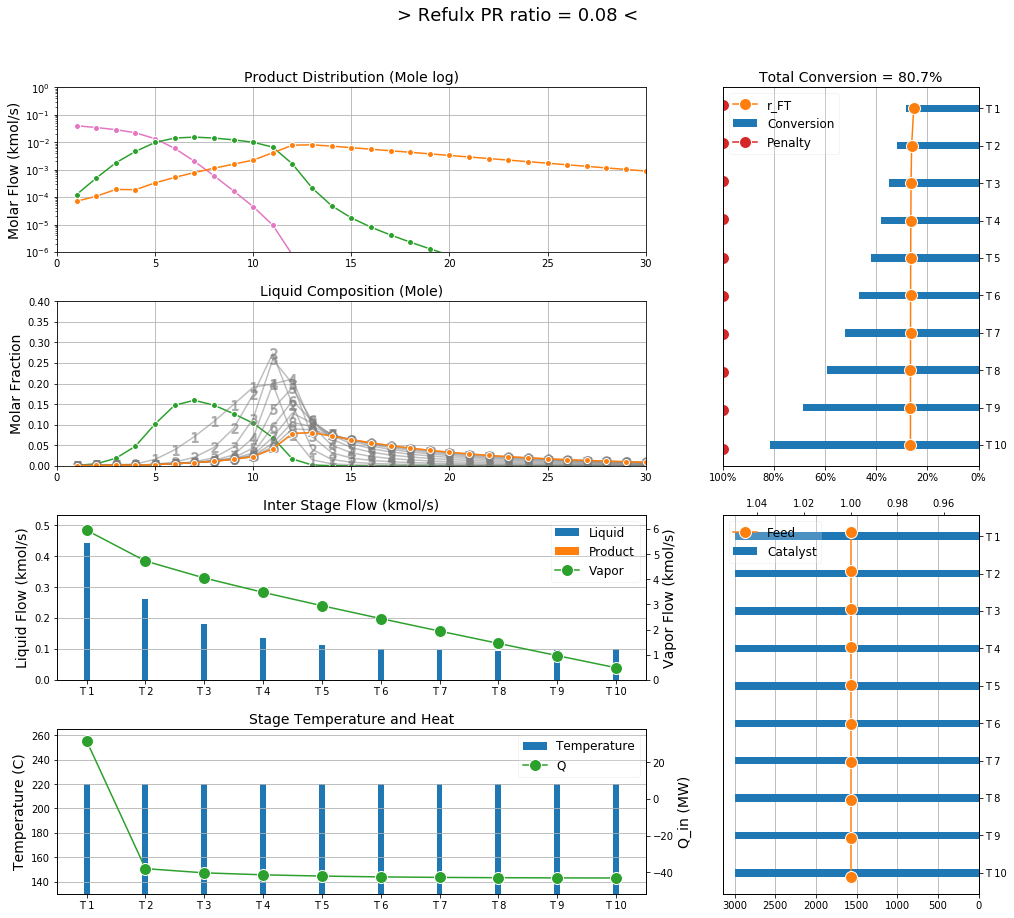


> Working on Reflux, PR ratio = 0.06
------------------------------------------------------------------------------------------------------------
Here comes the result:
------------------------------------------------------------------------------------------------------------
stages			T	Q				V_out	L_out	L_Prod		W
Condenser		30.00	-228.				2.6527	1.3658	0.0910		2.0514

stages			T	Q	r_FT	Conversion	V_out	L_out	L_Prod		P_VLE
React-ive[1]		220.0	43.37	0.2512	0.282		6.1610	0.5541	0.0000		20.000
React-ive[2]		220.0	-37.1	0.2602	0.316		4.8366	0.3322	0.0000		20.000
React-ive[3]		220.0	-39.6	0.2627	0.347		4.1194	0.2289	0.0000		20.000
React-ive[4]		220.0	-40.9	0.2638	0.380		3.5257	0.1689	0.0000		20.000
React-ive[5]		220.0	-41.7	0.2645	0.418		2.9773	0.1334	0.0000		20.000
React-ive[6]		220.0	-42.2	0.2650	0.464		2.4550	0.1141	0.0000		20.000
React-ive[7]		220.0	-42.6	0.2653	0.521		1.9498	0.1049	0.0000		20.000
React-ive[8]		220.0	-42.8	0.2655	0.592		1.4552	0.1015	0.0000		20.000
React-ive[9]		220.0	

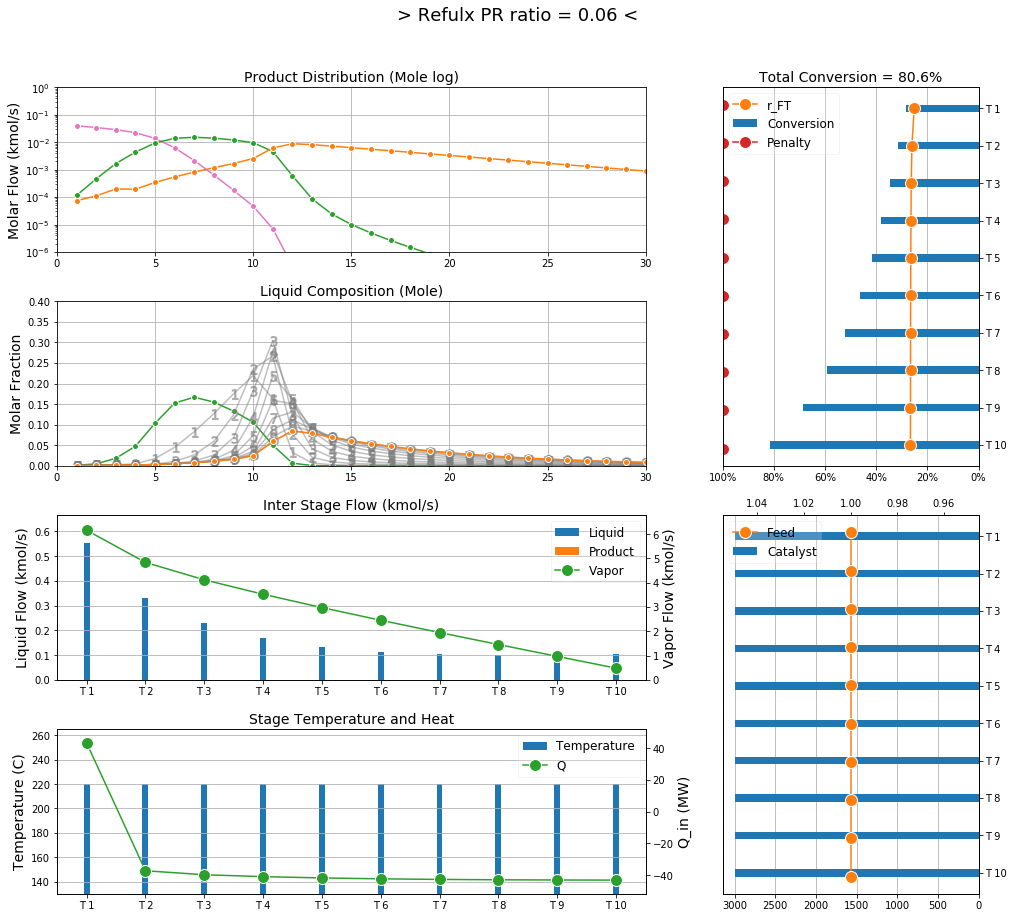


> Working on Reflux, PR ratio = 0.05
------------------------------------------------------------------------------------------------------------
Here comes the result:
------------------------------------------------------------------------------------------------------------
stages			T	Q				V_out	L_out	L_Prod		W
Condenser		30.00	-240.				2.6695	1.5586	0.0865		2.0452

stages			T	Q	r_FT	Conversion	V_out	L_out	L_Prod		P_VLE
React-ive[1]		220.0	53.95	0.2496	0.278		6.3600	0.6601	0.0000		20.000
React-ive[2]		220.0	-36.4	0.2591	0.314		4.9457	0.4005	0.0000		20.000
React-ive[3]		220.0	-39.0	0.2620	0.345		4.1887	0.2746	0.0000		20.000
React-ive[4]		220.0	-40.4	0.2633	0.378		3.5711	0.1991	0.0000		20.000
React-ive[5]		220.0	-41.3	0.2642	0.417		3.0063	0.1529	0.0000		20.000
React-ive[6]		220.0	-42.0	0.2648	0.464		2.4724	0.1265	0.0000		20.000
React-ive[7]		220.0	-42.4	0.2652	0.520		1.9597	0.1130	0.0000		20.000
React-ive[8]		220.0	-42.7	0.2654	0.592		1.4605	0.1072	0.0000		20.000
React-ive[9]		220.0	

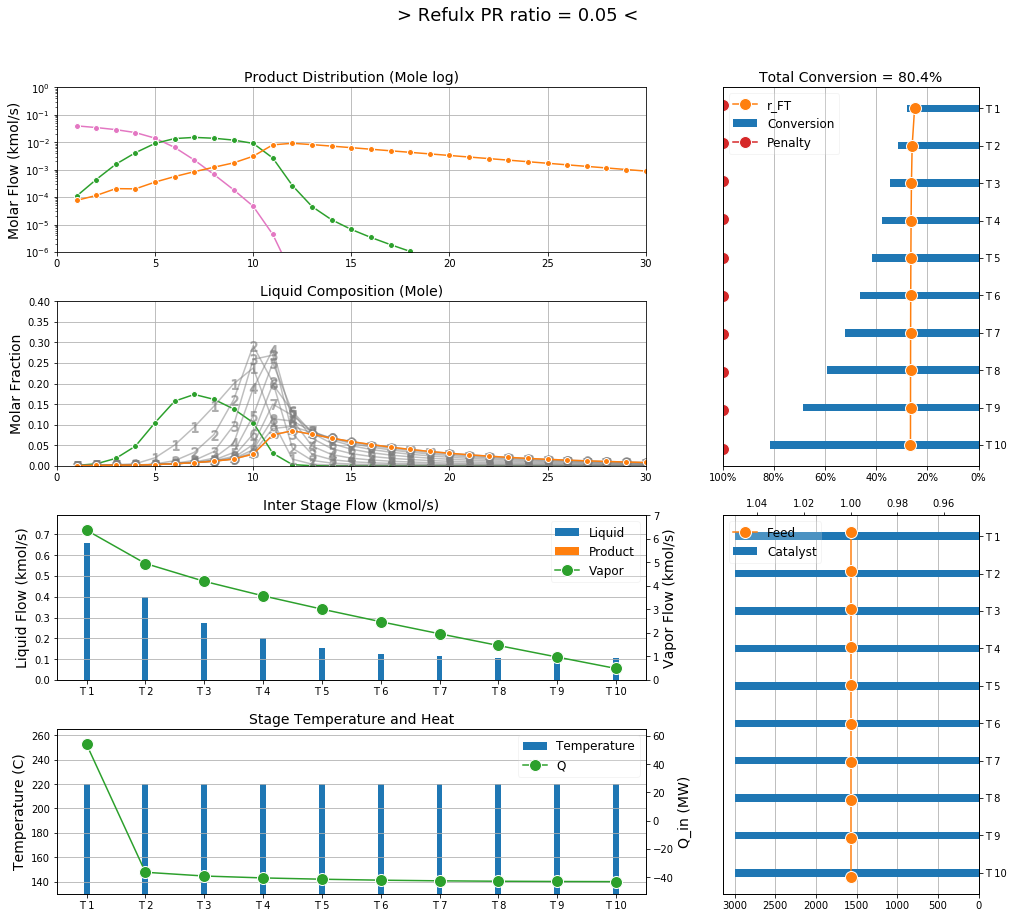


> Working on reboiler temperature = 623.15
------------------------------------------------------------------------------------------------------------
Here comes the result:
------------------------------------------------------------------------------------------------------------
stages			T	Q				V_out	L_out	L_Prod		W
Condenser		30.00	-241.				2.6736	1.5632	0.0868		2.0486

stages			T	Q	r_FT	Conversion	V_out	L_out	L_Prod		P_VLE
React-ive[1]		220.0	54.21	0.2496	0.278		6.3724	0.6623	0.0000		20.000
React-ive[2]		220.0	-36.4	0.2591	0.313		4.9556	0.4020	0.0000		20.000
React-ive[3]		220.0	-39.0	0.2620	0.344		4.1979	0.2758	0.0000		20.000
React-ive[4]		220.0	-40.4	0.2633	0.378		3.5799	0.2000	0.0000		20.000
React-ive[5]		220.0	-41.3	0.2641	0.417		3.0148	0.1535	0.0000		20.000
React-ive[6]		220.0	-42.0	0.2647	0.463		2.4806	0.1270	0.0000		20.000
React-ive[7]		220.0	-42.4	0.2651	0.519		1.9676	0.1134	0.0000		20.000
React-ive[8]		220.0	-42.7	0.2654	0.591		1.4683	0.1075	0.0000		20.000
React-ive[9]		

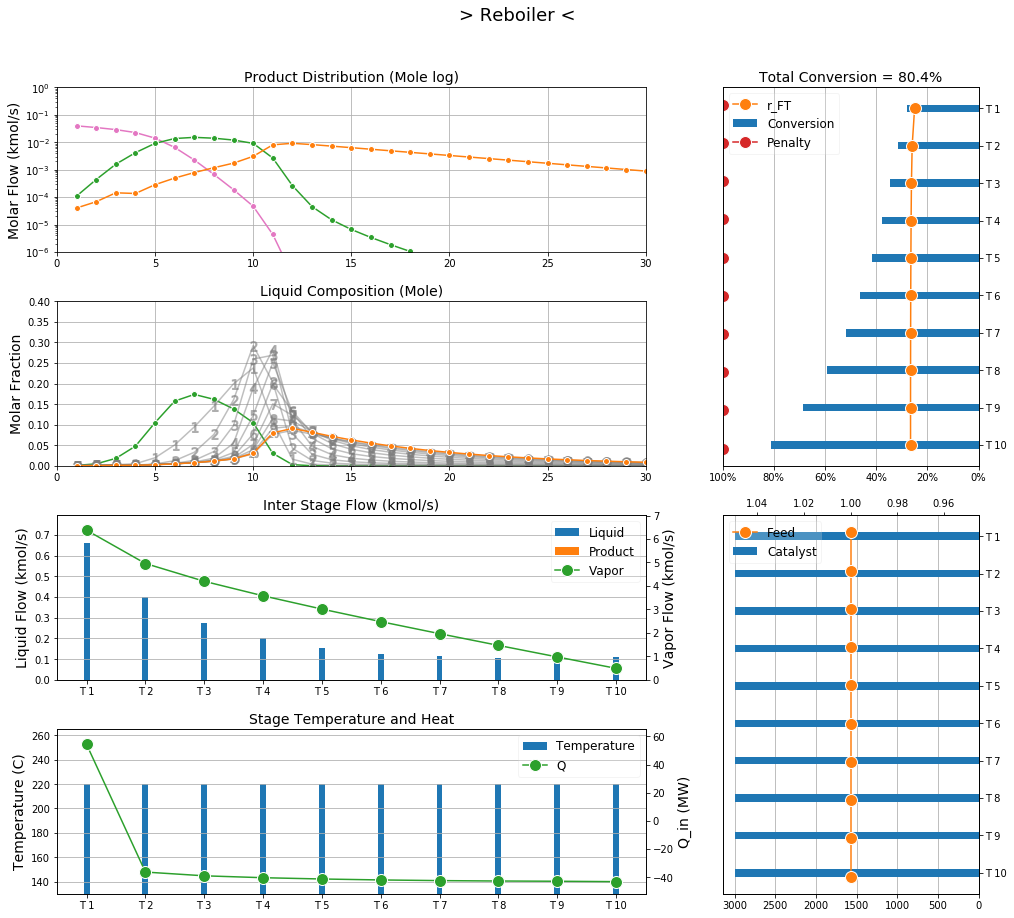


> Working to remove catalyst and feed from stage 1, unfixing temperature, changing to adiabatic:
------------------------------------------------------------------------------------------------------------
stages			T	Q	r_FT	Conversion	V_out	L_out	L_Prod		P_VLE
NON-react[1]		182.0	0.000	0.0000	0.000		5.3783	1.5111	0.0000		20.000
React-ive[2]		220.0	-10.0	0.2514	0.295		5.8531	0.9330	0.0000		20.000
React-ive[3]		220.0	-35.8	0.2571	0.330		4.7627	0.6671	0.0000		20.000
React-ive[4]		220.0	-37.3	0.2591	0.365		3.9954	0.4783	0.0000		20.000
React-ive[5]		220.0	-38.4	0.2606	0.405		3.3092	0.3333	0.0000		20.000
React-ive[6]		220.0	-39.6	0.2620	0.454		2.6697	0.2294	0.0000		20.000
React-ive[7]		220.0	-40.8	0.2633	0.513		2.0739	0.1661	0.0000		20.000
React-ive[8]		220.0	-41.8	0.2643	0.586		1.5213	0.1332	0.0000		20.000
React-ive[9]		220.0	-42.4	0.2648	0.681		1.0010	0.1183	0.0000		20.000
React-ive[10]		220.0	-43.0	0.2650	0.809		0.4998	0.1145	0.0000		20.000
2018-07-06 20:19:30 - Elapsed time from last lo

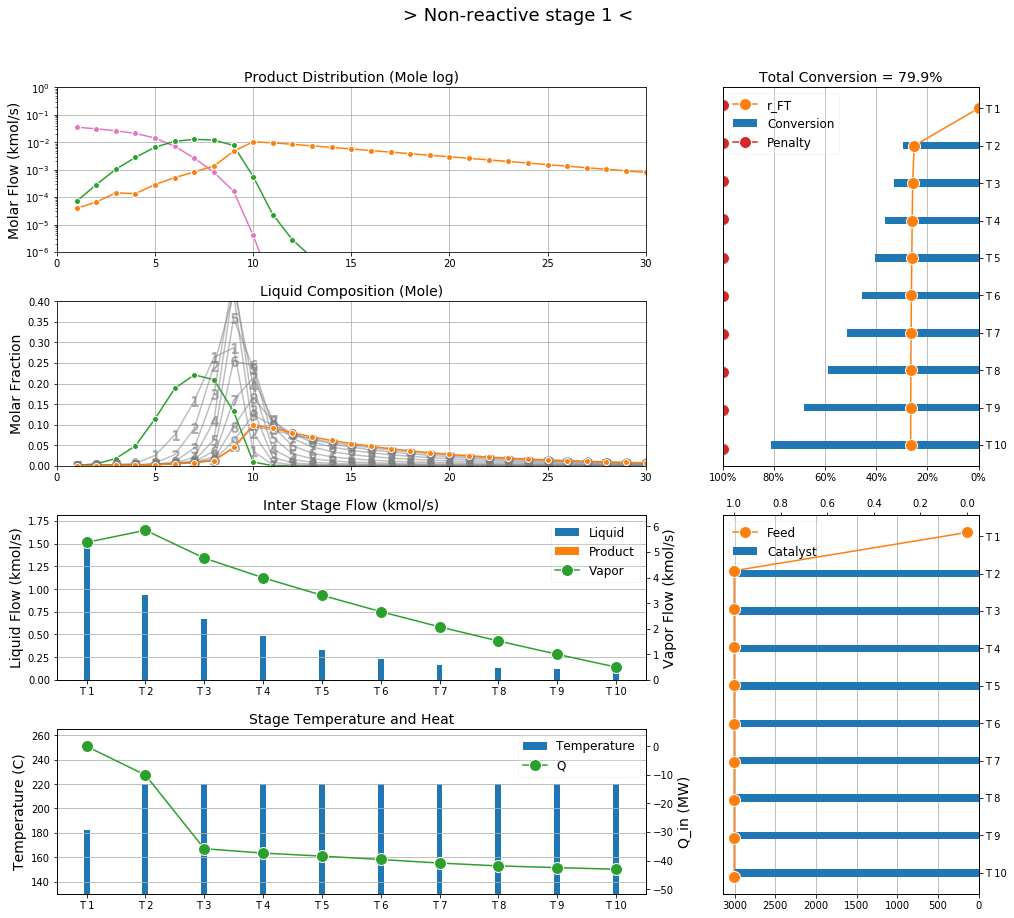


> Working to remove catalyst and feed from stage 2, unfixing temperature, changing to adiabatic:
------------------------------------------------------------------------------------------------------------
stages			T	Q	r_FT	Conversion	V_out	L_out	L_Prod		P_VLE
NON-react[1]		169.9	0.000	0.0000	0.000		4.6650	1.1597	0.0000		20.000
NON-react[2]		201.9	0.000	0.0000	0.000		5.0154	1.2013	0.0000		20.000
React-ive[3]		220.0	-25.7	0.2545	0.323		5.0569	0.8358	0.0000		20.000
React-ive[4]		220.0	-36.4	0.2575	0.359		4.1851	0.6068	0.0000		20.000
React-ive[5]		220.0	-37.5	0.2591	0.400		3.4556	0.4265	0.0000		20.000
React-ive[6]		220.0	-38.5	0.2605	0.449		2.7778	0.2848	0.0000		20.000
React-ive[7]		220.0	-39.8	0.2621	0.509		2.1415	0.1892	0.0000		20.000
React-ive[8]		220.0	-41.2	0.2635	0.584		1.5543	0.1375	0.0000		20.000
React-ive[9]		220.0	-42.1	0.2645	0.680		1.0136	0.1141	0.0000		20.000
React-ive[10]		220.0	-42.9	0.2648	0.809		0.5033	0.1071	0.0000		20.000
2018-07-06 20:19:54 - Elapsed time from last lo

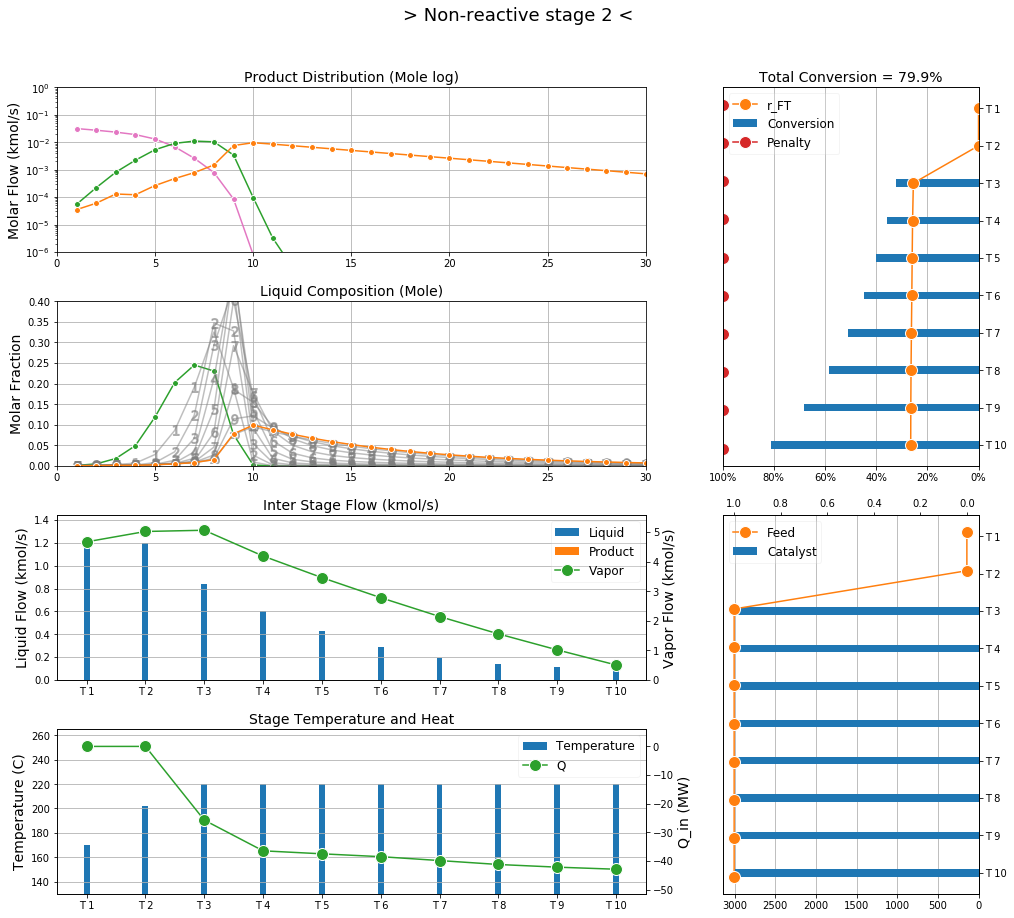


> Working to remove catalyst and feed from stage 3, unfixing temperature, changing to adiabatic:
------------------------------------------------------------------------------------------------------------
stages			T	Q	r_FT	Conversion	V_out	L_out	L_Prod		P_VLE
NON-react[1]		164.0	0.000	0.0000	0.000		4.0346	0.9474	0.0000		20.000
NON-react[2]		193.0	0.000	0.0000	0.000		4.3171	0.9739	0.0000		20.000
NON-react[3]		209.1	0.000	0.0000	0.000		4.3436	0.9702	0.0000		20.000
React-ive[4]		220.0	-31.3	0.2560	0.355		4.3398	0.6888	0.0000		20.000
React-ive[5]		220.0	-36.9	0.2581	0.397		3.5549	0.4828	0.0000		20.000
React-ive[6]		220.0	-37.8	0.2596	0.446		2.8496	0.3173	0.0000		20.000
React-ive[7]		220.0	-39.2	0.2613	0.506		2.1875	0.1993	0.0000		20.000
React-ive[8]		220.0	-40.8	0.2630	0.582		1.5763	0.1336	0.0000		20.000
React-ive[9]		220.0	-41.9	0.2642	0.679		1.0207	0.1046	0.0000		20.000
React-ive[10]		220.0	-42.8	0.2647	0.809		0.5043	0.0958	0.0000		20.000
2018-07-06 20:20:08 - Elapsed time from last lo

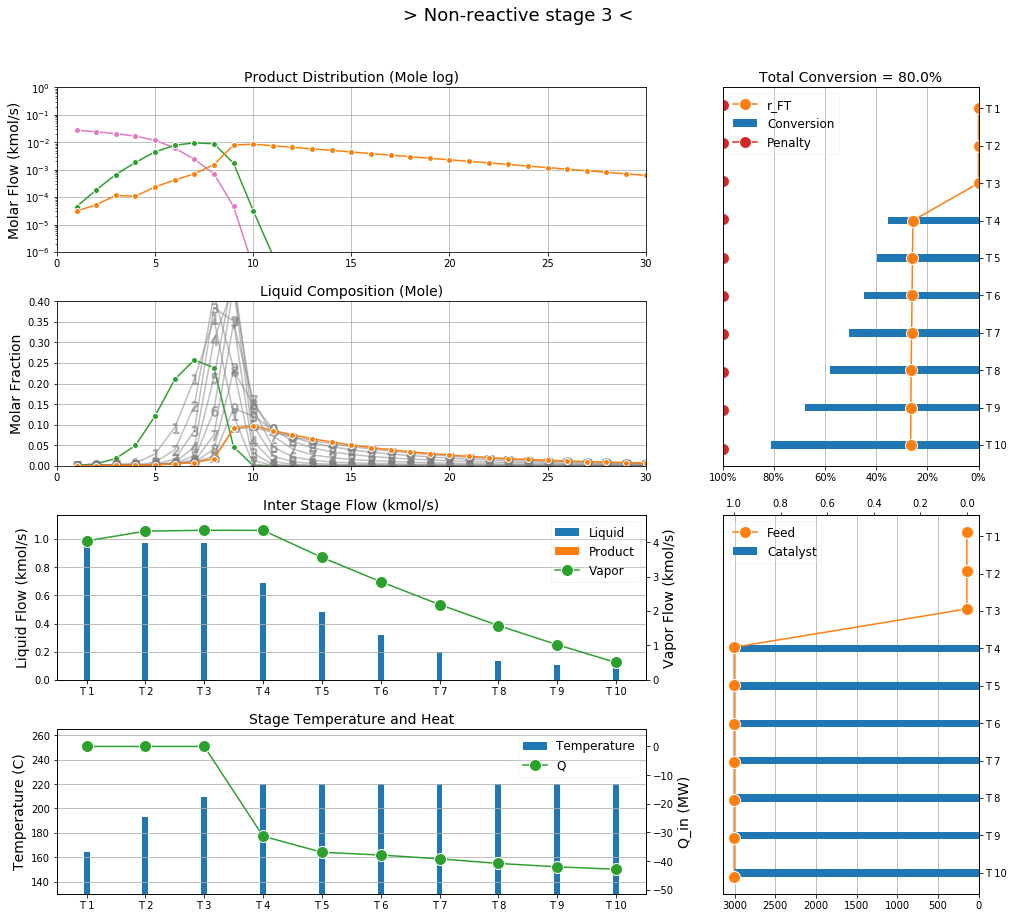


> Working to remove catalyst and feed from stage 5, unfixing temperature, changing to adiabatic:
------------------------------------------------------------------------------------------------------------
stages			T	Q	r_FT	Conversion	V_out	L_out	L_Prod		P_VLE
NON-react[1]		164.1	0.000	0.0000	0.000		3.4578	0.8154	0.0000		20.000
NON-react[2]		193.1	0.000	0.0000	0.000		3.7016	0.8392	0.0000		20.000
NON-react[3]		209.1	0.000	0.0000	0.000		3.7254	0.8369	0.0000		20.000
React-ive[4]		220.0	-31.1	0.2553	0.391		3.7231	0.5640	0.0000		20.000
NON-react[5]		217.0	0.000	0.0000	0.000		2.9453	0.5001	0.0000		20.000
React-ive[6]		220.0	-37.0	0.2592	0.444		2.8815	0.3263	0.0000		20.000
React-ive[7]		220.0	-38.8	0.2608	0.505		2.2104	0.1971	0.0000		20.000
React-ive[8]		220.0	-40.5	0.2627	0.582		1.5871	0.1229	0.0000		20.000
React-ive[9]		220.0	-41.9	0.2641	0.679		1.0225	0.0913	0.0000		20.000
React-ive[10]		220.0	-42.8	0.2648	0.809		0.5032	0.0821	0.0000		20.000
2018-07-06 20:20:23 - Elapsed time from last lo

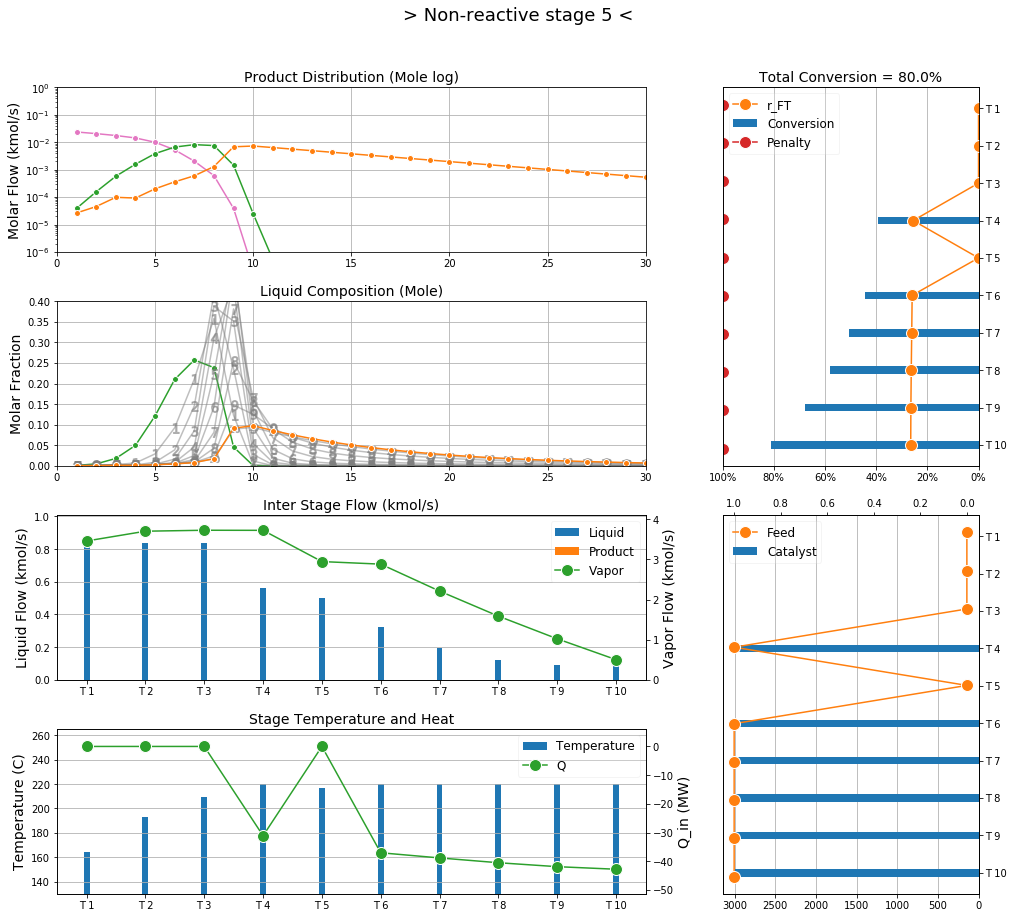


> Working to remove catalyst and feed from stage 10, unfixing temperature, changing to adiabatic:
------------------------------------------------------------------------------------------------------------
stages			T	Q	r_FT	Conversion	V_out	L_out	L_Prod		P_VLE
NON-react[1]		163.5	0.000	0.0000	0.000		2.8738	0.6687	0.0000		20.000
NON-react[2]		192.4	0.000	0.0000	0.000		3.0715	0.6845	0.0000		20.000
NON-react[3]		208.6	0.000	0.0000	0.000		3.0874	0.6767	0.0000		20.000
React-ive[4]		220.0	-31.9	0.2556	0.437		3.0796	0.4211	0.0000		20.000
NON-react[5]		216.0	0.000	0.0000	0.000		2.3198	0.3596	0.0000		20.000
React-ive[6]		220.0	-37.5	0.2599	0.503		2.2584	0.2044	0.0000		20.000
React-ive[7]		220.0	-40.0	0.2622	0.580		1.6073	0.1144	0.0000		20.000
React-ive[8]		220.0	-41.7	0.2640	0.679		1.0259	0.0779	0.0000		20.000
React-ive[9]		220.0	-42.6	0.2649	0.810		0.5014	0.0669	0.0000		20.000
NON-react[10]		229.2	0.000	0.0000	0.000		0.0043	0.0721	0.0000		20.000
2018-07-06 20:21:30 - Elapsed time from last l

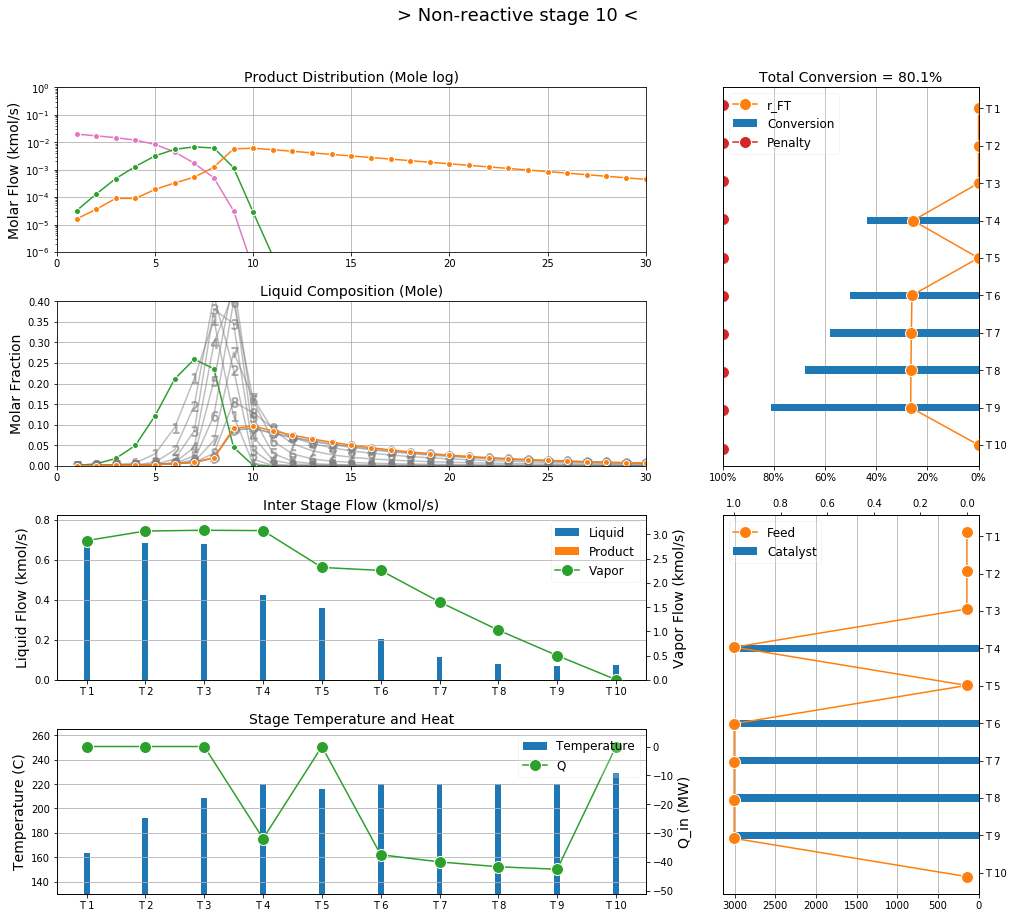


> Working on side draw of 20.0% on stage 4
------------------------------------------------------------------------------------------------------------
Here comes the result:
------------------------------------------------------------------------------------------------------------
stages			T	Q				V_out	L_out	L_Prod		W
Condenser		30.00	-76.3				1.3169	0.3850	0.0213		1.0306

stages			T	Q	r_FT	Conversion	V_out	L_out	L_Prod		P_VLE
NON-react[1]		152.6	0.000	0.0000	0.000		2.7540	0.5008	0.0000		20.000
NON-react[2]		179.8	0.000	0.0000	0.000		2.8699	0.4554	0.0000		20.000
NON-react[3]		199.7	0.000	0.0000	0.000		2.8244	0.3833	0.0000		20.000
React-ive[4]		220.0	-31.8	0.2585	0.452		2.7523	0.1145	0.0286		20.000
NON-react[5]		211.0	0.000	0.0000	0.000		2.0135	0.0664	0.0000		20.000
React-ive[6]		220.0	-41.7	0.2649	0.520		1.9654	0.0398	0.0000		20.000
React-ive[7]		220.0	-42.8	0.2656	0.593		1.4526	0.0361	0.0000		20.000
React-ive[8]		220.0	-43.1	0.2658	0.686		0.9641	0.0386	0.0000		20.000
React-ive[9]		

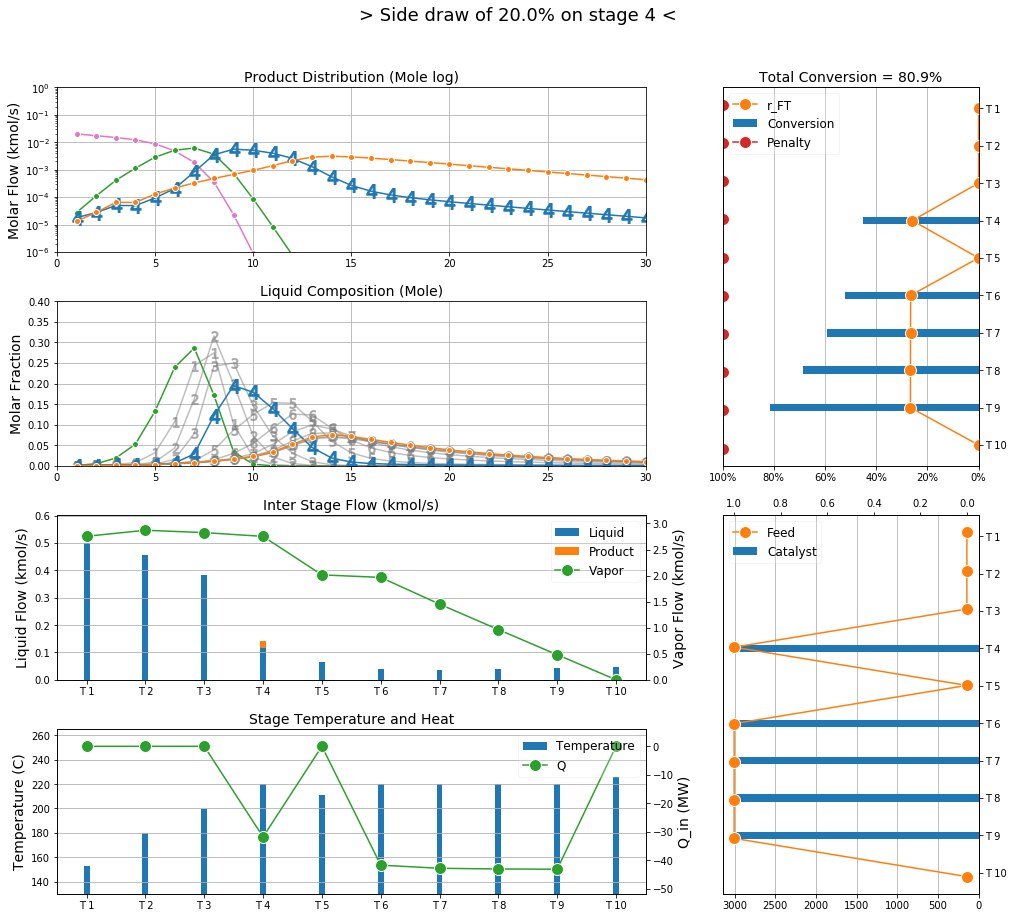


> Working on side draw of 70.0% on stage 7
------------------------------------------------------------------------------------------------------------
Here comes the result:
------------------------------------------------------------------------------------------------------------
stages			T	Q				V_out	L_out	L_Prod		W
Condenser		30.00	-76.3				1.3156	0.3857	0.0214		1.0303

stages			T	Q	r_FT	Conversion	V_out	L_out	L_Prod		P_VLE
NON-react[1]		152.7	0.000	0.0000	0.000		2.7531	0.5024	0.0000		20.000
NON-react[2]		179.9	0.000	0.0000	0.000		2.8698	0.4577	0.0000		20.000
NON-react[3]		199.7	0.000	0.0000	0.000		2.8251	0.3854	0.0000		20.000
React-ive[4]		220.0	-31.6	0.2584	0.452		2.7528	0.1119	0.0279		20.000
NON-react[5]		210.5	0.000	0.0000	0.000		2.0085	0.0626	0.0000		20.000
React-ive[6]		220.0	-41.7	0.2649	0.521		1.9591	0.0368	0.0000		20.000
React-ive[7]		220.0	-42.8	0.2656	0.593		1.4473	0.0099	0.0231		20.000
React-ive[8]		220.0	-43.2	0.2659	0.687		0.9586	0.0146	0.0000		20.000
React-ive[9]		

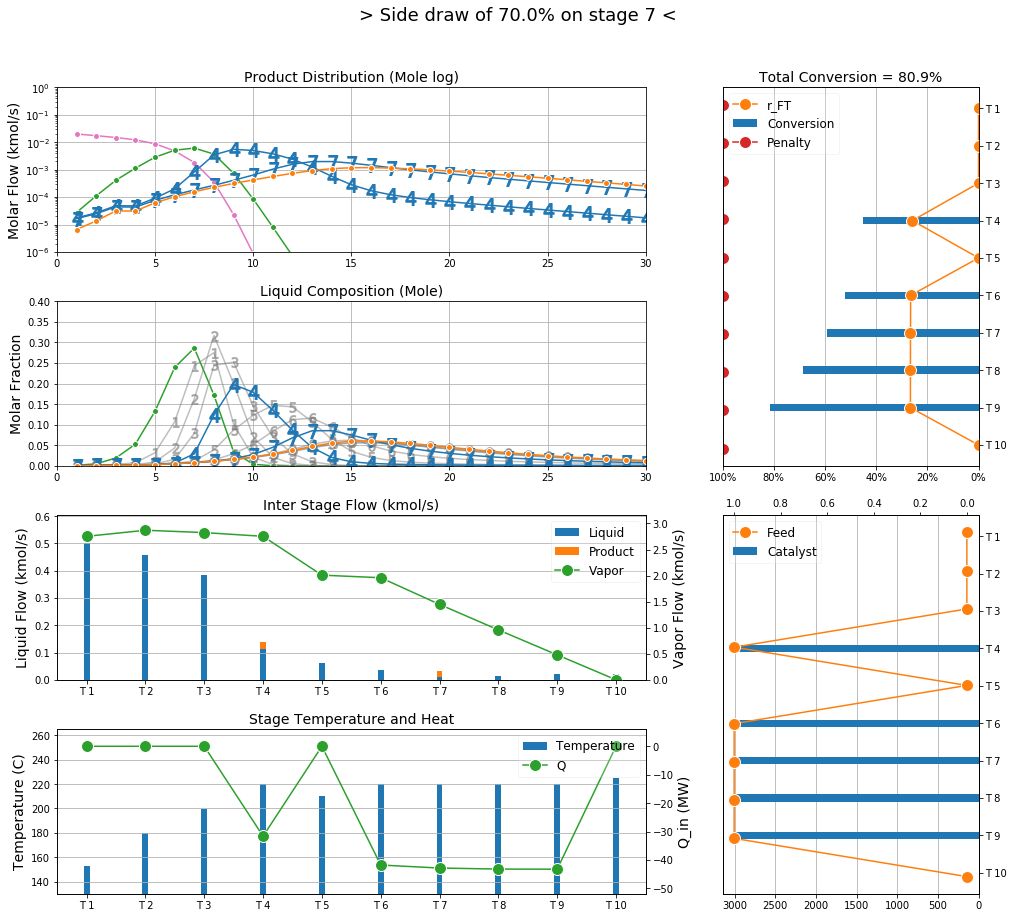


> Working on adjusting stage 6 temperature to 240.00C 
------------------------------------------------------------------------------------------------------------
Here comes the result:
------------------------------------------------------------------------------------------------------------
stages			T	Q				V_out	L_out	L_Prod		W
Condenser		30.00	-81.1				1.1885	0.4578	0.0254		1.0954

stages			T	Q	r_FT	Conversion	V_out	L_out	L_Prod		P_VLE
NON-react[1]		149.4	0.000	0.0000	0.000		2.7673	0.5919	0.0000		20.000
NON-react[2]		175.8	0.000	0.0000	0.000		2.9014	0.5338	0.0000		20.000
NON-react[3]		196.9	0.000	0.0000	0.000		2.8433	0.4423	0.0000		20.000
React-ive[4]		220.0	-29.3	0.2374	0.466		2.7518	0.1468	0.0367		20.000
NON-react[5]		225.3	0.000	0.0000	0.000		1.9535	0.0891	0.0000		20.000
React-ive[6]		240.0	-45.7	0.3225	0.643		1.8958	0.0291	0.0000		20.000
React-ive[7]		220.0	-43.1	0.2656	0.594		1.4460	0.0078	0.0182		20.000
React-ive[8]		220.0	-43.2	0.2659	0.687		0.9582	0.0128	0.0000		20.000
Re

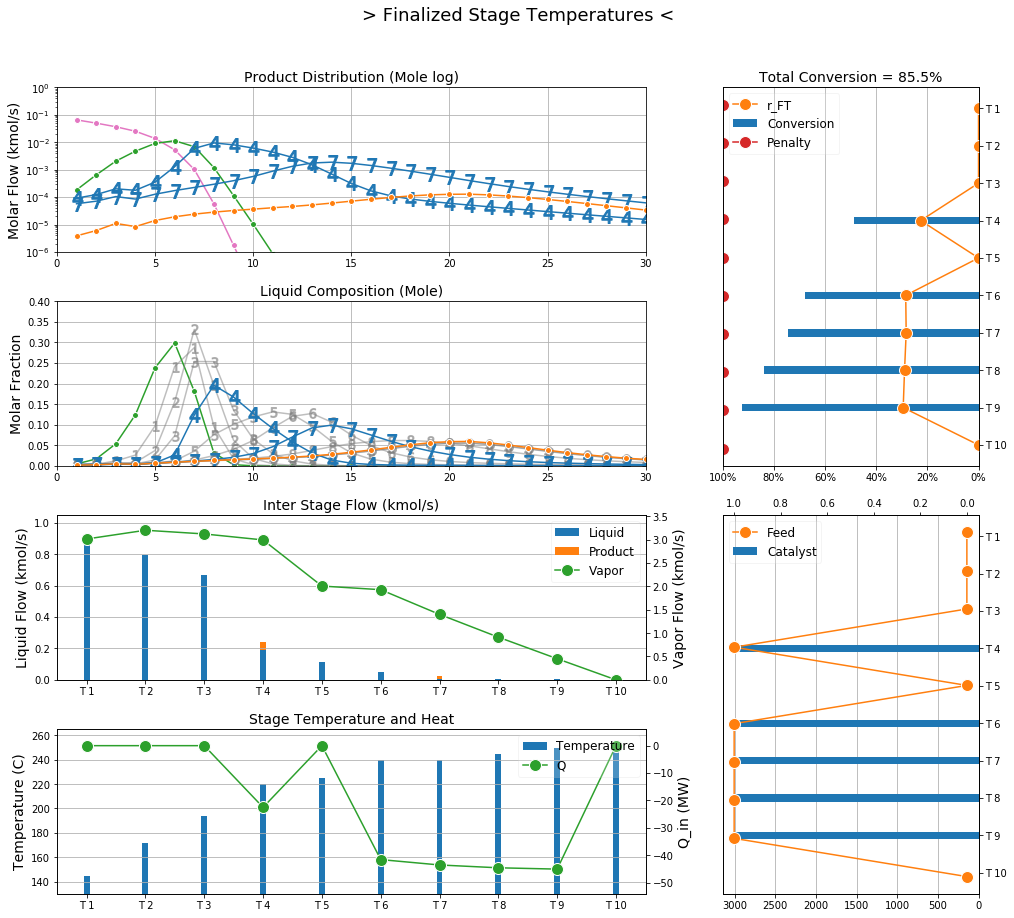

2018-07-06 20:23:06 - End Program
Elapsed time: 0:06:40
Initialization Complete
Please check the logs for details


In [1]:
%matplotlib inline
# %load ../../utility/initialization.py
'''
How to Train Your Dragon: V2
Sequentially initialize FT reactive distillation model automatically
'''
# system imports
import sys
import os
import datetime
sys.path.append(os.path.abspath('..'))
sys.path.append(os.path.abspath('../..'))

import numpy as np
from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

import pickle
import dill
from copy import deepcopy

# pyomo imports
from pyomo import environ as pe
from global_sets.component import m

from stages.reactive_stage import reactive_stage_rule
from stages.condenser_stage import condenser_stage_rule
from stages.reboiler_stage import reboiler_stage_rule

from utility.display_utility import trans_product_mole, trans_product_mass, beautify, \
                                    beautify_reactive, HiddenLogs, HiddenPrints, plot_distribution
from utility.model_utility import add_dual, update_dual, delete_dual, check_DOF, check_violate_constraint
from utility.data_utility import cal_cnumber
from utility.time_utility import create_filename_time, log_now, log_end

'''
Constructing the model and logfile
'''

model = pe.ConcreteModel(name='reactive_distillation')
logname = create_filename_time()
log_text_dir = './log/text/'+logname+'.dat'
log_figure_dir = './log/figure/'+logname+'.pdf'

'''
model input
'''
tray_number = 10
non_reactive_flag = [1,2,3,5,10]
# non_reactive_flag = []
side_draw_flag = {4:0.2,7:0.7}
# default temperature is 220C
temperature_flag = {6:240,7:240,8:245,9:250}
rr_ratio = 0.05

with PdfPages(log_figure_dir,keep_empty=True) as pdf:
    '''
    construct the reactive stages
    '''
    model.TRAY = pe.RangeSet(1,tray_number)
    model.TRAY_nonreactive = pe.Set(initialize=non_reactive_flag)
    model.TRAY_reactive = model.TRAY - model.TRAY_nonreactive

    with HiddenPrints():
        model.reactive = pe.Block(model.TRAY,rule=reactive_stage_rule)
        add_dual(pe,model)

    '''
    setting stream variables
    '''
    # in/out variable
    for j in model.reactive:
        model.reactive[j].x_.fix(0)
        model.reactive[j].y_.fix(0)
        model.reactive[j].L['in'].fix(0)
        model.reactive[j].V['in'].fix(0)
        model.reactive[j].H_L_.fix(0)
        model.reactive[j].H_V_.fix(0)

    # operating parameters
    for j in model.reactive:
        model.reactive[j].cat.fix(3000)
        model.reactive[j].P.fix(20)
        model.reactive[j].VLE_block.n_ave.fix(20)

        model.reactive[j].F.fix(1)
        model.reactive[j].T_F.fix(200+273.15)
        model.reactive[j].z['CO'].fix(1/(1+2)-0/2)
        model.reactive[j].z['H2'].fix(2/(1+2)-0/2)
        model.reactive[j].z['C30H62'].fix(0)

        model.reactive[j].PR_L.fix(1)
        model.reactive[j].PR_V.fix(1)

        # model.reactive[j].Q_main.fix(0)
        model.reactive[j].T.setub(220+273.15)
        model.reactive[j].T.setlb(200+273.15)

    model.obj = pe.Objective(expr = sum(model.reactive[j].T - model.reactive[j].MPCC.pf \
                                        for j in model.reactive),sense=pe.maximize)

    '''
    solver options
    '''
    try:
        opt = pe.SolverFactory('ipopt')

        opt.options['print_user_options'] = 'yes'
        opt.options['linear_solver'] = 'ma86'

        opt.options['linear_system_scaling '] = 'mc19'
        opt.options['linear_scaling_on_demand '] = 'no'

        opt.options['max_iter'] = 7000

        results = opt.solve(model,tee=False)
        update_dual(pe,model)
    except:
        opt = None
        opt = pe.SolverFactory('ipopt')

        opt.options['print_user_options'] = 'yes'
        opt.options['linear_scaling_on_demand '] = 'no'

        opt.options['max_iter'] = 7000

        results = opt.solve(model,tee=False)
        update_dual(pe,model)

    
    with HiddenLogs(log_text_dir,'w'):
        print('\n> First Solve, disconnected reactive stages')
        print('-'*108)
        beautify_reactive(pe,model)
        log_now()
    
    '''
    connect reactive stages
    '''

    def V_between_rule(model,j):
        if j == model.TRAY.last(): return pe.Constraint.Skip
        return model.reactive[j].V['in'] == model.reactive[j+1].V['out']
    model.V_between_con = pe.Constraint(model.TRAY,rule=V_between_rule)

    def Vy_between_rule(model,j,i):
        if j == model.TRAY.last(): return pe.Constraint.Skip
        return model.reactive[j].y_['in',i] == model.reactive[j+1].y[i]
    model.Vy_between_con = pe.Constraint(model.TRAY,m.COMP_TOTAL,rule=Vy_between_rule)

    def Vh_between_rule(model,j):
        if j == model.TRAY.last(): return pe.Constraint.Skip
        return model.reactive[j].H_V_['in'] == model.reactive[j+1].H_V
    model.Vh_between_con = pe.Constraint(model.TRAY,rule=Vh_between_rule)

    def L_between_rule(model,j):
        if j == model.TRAY.last(): return pe.Constraint.Skip
        return model.reactive[j+1].L['in'] == model.reactive[j].L['out']
    model.L_between_con = pe.Constraint(model.TRAY,rule=L_between_rule)

    def Lx_between_rule(model,j,i):
        if j == model.TRAY.last(): return pe.Constraint.Skip
        return model.reactive[j+1].x_['in',i] == model.reactive[j].x[i]
    model.Ly_between_con = pe.Constraint(model.TRAY,m.COMP_TOTAL,rule=Lx_between_rule)

    def Lh_between_rule(model,j):
        if j == model.TRAY.last(): return pe.Constraint.Skip
        return model.reactive[j+1].H_L_['in'] == model.reactive[j].H_L
    model.Lh_between_con = pe.Constraint(model.TRAY,rule=Lh_between_rule)

    for j in model.reactive:
        if j != model.TRAY.first():
            model.reactive[j].x_.unfix()
            model.reactive[j].H_L_.unfix()
            model.reactive[j].L['in'].unfix()
        if j != model.TRAY.last():
            model.reactive[j].y_.unfix()
            model.reactive[j].V['in'].unfix()
            model.reactive[j].H_V_.unfix()

    '''
    warm start options
    '''        

    opt.options['warm_start_init_point'] = 'yes'
    opt.options['warm_start_bound_push'] = 1e-20
    opt.options['warm_start_mult_bound_push'] = 1e-20
    opt.options['mu_init'] = 1e-6

    results = opt.solve(model,tee=False)
    update_dual(pe,model)

    '''
    The model above has liquid and vapor leave stage as products
    Now let liquid and vapor flow up/down stages
    '''

    PR_range = np.linspace(0.8,0,5)
    with HiddenLogs(log_text_dir):
        print('\n> Connect stages and introduce inter-stage flow')
        log_now()
    for r in PR_range:
        for j in model.reactive:
            model.reactive[j].PR_L.fix(r)
            model.reactive[j].PR_V.fix(r)

        results = opt.solve(model,tee=False)
        update_dual(pe,model)
        with HiddenLogs(log_text_dir):
            print('\n>','Working on PR ratio = {:.2f}'.format(r))
            print('-'*108)
            beautify_reactive(pe,model)
            log_now()
    
    '''
    Deactivate reactive part of the model to initialize condenser and reboiler
    '''    

    for i in model.block_data_objects():
        if i.name != 'reactive_distillation':
            i.deactivate()
    for i in model.component_objects(pe.Constraint, active=True):
        i.deactivate()

    with HiddenPrints():
        model.condenser = pe.Block(rule=condenser_stage_rule)
        delete_dual(pe,model)
        add_dual(pe,model)
        
    '''
    setting condenser stream variables to match reactive stages vapor output
    '''

    # in/out variables
    model.condenser.x_.fix(0)
    for i in m.COMP_TOTAL:
        model.condenser.y_['in',i].fix(model.reactive[model.TRAY.first()].y[i].value)
    model.condenser.V['in'].fix(model.reactive[model.TRAY.first()].V['out'].value)
    model.condenser.L['in'].fix(0)
    model.condenser.V['P'].fix(0)
    model.condenser.H_L_.fix(0)
    model.condenser.H_V_.fix(model.reactive[model.TRAY.first()].H_V.value)

    # operating parameters
    model.condenser.P.fix(19)
    model.condenser.T_F.fix(200+273.15)
    model.condenser.F.fix(0)
    model.condenser.z.fix(0)
    model.condenser.VLE_block.n_ave.fix(4)
    model.condenser.PR_L.fix(1)

    model.condenser.T.setub(30+273.15)

    model.del_component(model.obj)
    model.obj = pe.Objective(expr = model.condenser.T, sense = pe.maximize)

    results = opt.solve(model,tee=False)
    update_dual(pe,model)

    model.condenser.deactivate()

    with HiddenPrints():
        model.reboiler = pe.Block(rule=reboiler_stage_rule)
        delete_dual(pe,model)
        add_dual(pe,model)

    '''
    setting reboiler stream variables to match reactive stages vapor output
    '''

    # in/out variables
    model.reboiler.y_.fix(0)
    for i in m.COMP_TOTAL:
        model.reboiler.x_['in',i].fix(model.reactive[model.TRAY.last()].x[i].value)
    model.reboiler.L['in'].fix(model.reactive[model.TRAY.last()].L['out'].value)
    model.reboiler.V['in'].fix(0)
    model.reboiler.L['P'].fix(0)
    model.reboiler.V['P'].fix(0)
    model.reboiler.H_L_.fix(model.reactive[model.TRAY.last()].H_L.value)
    model.reboiler.H_V_.fix(0)

    # operating parameters
    model.reboiler.P.fix(20)
    model.reboiler.T_F.fix(200+273.15)
    model.reboiler.F.fix(0)
    model.reboiler.z['CO'].fix(1/(1+2)-0/2)
    model.reboiler.z['H2'].fix(2/(1+2)-0/2)
    model.reboiler.z['C30H62'].fix(0)
    model.reboiler.VLE_block.n_ave.fix(20)

    model.reboiler.T.setub(model.reactive[model.TRAY.last()].T.value)

    model.del_component(model.obj)
    model.obj = pe.Objective(expr = model.reboiler.T - model.reboiler.MPCC.pf, sense = pe.maximize)

    results = opt.solve(model,tee=False)
    update_dual(pe,model)

    '''
    Now all the variables are initialized, reactivate everything, time to connect condenser and reboiler
    '''

    for i in model.block_data_objects():
        if i.name != 'reactive_distillation':
            i.activate()
    for i in model.component_objects(pe.Constraint):
        i.activate()

    def V_condenser_rule(model):
        return model.reactive[model.TRAY.first()].V['out'] == model.condenser.V['in']
    model.V_condenser_con = pe.Constraint(rule=V_condenser_rule)

    def Vy_condenser_rule(model,i):
        return model.reactive[model.TRAY.first()].y[i] == model.condenser.y_['in',i]
    model.Vy_condenser_con = pe.Constraint(m.COMP_TOTAL,rule=Vy_condenser_rule)

    def Vh_condenser_rule(model):
        return model.reactive[model.TRAY.first()].H_V == model.condenser.H_V_['in']
    model.Vh_condenser_con = pe.Constraint(rule=Vh_condenser_rule)

    def L_condenser_rule(model):
        return model.reactive[model.TRAY.first()].L['in'] == model.condenser.L['out']
    model.L_condenser_con = pe.Constraint(rule=L_condenser_rule)

    def Lx_condenser_rule(model,i):
        return model.reactive[model.TRAY.first()].x_['in',i] == model.condenser.x[i]
    model.Lx_condenser_con = pe.Constraint(m.COMP_TOTAL,rule=Lx_condenser_rule)

    def Lh_condenser_rule(model):
        return model.reactive[model.TRAY.first()].H_L_['in'] == model.condenser.H_L
    model.Lh_condenser_con = pe.Constraint(rule=Lh_condenser_rule)

    def V_reboiler_rule(model):
        return model.reactive[model.TRAY.last()].V['in'] == model.reboiler.V['out']
    model.V_reboiler_con = pe.Constraint(rule=V_reboiler_rule)

    def Vy_reboiler_rule(model,i):
        return model.reactive[model.TRAY.last()].y_['in',i] == model.reboiler.y[i]
    model.Vy_reboiler_con = pe.Constraint(m.COMP_TOTAL,rule=Vy_reboiler_rule)

    def Vh_reboiler_rule(model):
        return model.reactive[model.TRAY.last()].H_V_['in'] == model.reboiler.H_V
    model.Vh_reboiler_con = pe.Constraint(rule=Vh_reboiler_rule)

    def L_reboiler_rule(model):
        return model.reactive[model.TRAY.last()].L['out'] + 1e-6 == model.reboiler.L['in']
    model.L_reboiler_con = pe.Constraint(rule=L_reboiler_rule)

    def Lx_reboiler_rule(model,i):
        return model.reactive[model.TRAY.last()].x[i] == model.reboiler.x_['in',i]
    model.Lx_reboiler_con = pe.Constraint(m.COMP_TOTAL,rule=Lx_reboiler_rule)

    def Lh_reboiler_rule(model):
        return model.reactive[model.TRAY.last()].H_L == model.reboiler.H_L_['in']
    model.Lh_reboiler_con = pe.Constraint(rule=Lh_reboiler_rule)

    model.del_component(model.obj)
    model.obj = pe.Objective(expr = sum(model.reactive[j].T - model.reactive[j].MPCC.pf for j in model.TRAY)\
                             - model.reboiler.MPCC.pf ,sense=pe.maximize)

    with HiddenPrints():
        delete_dual(pe,model)
        add_dual(pe,model)

    '''
    Make sure all stream variables are set correctly
    '''

    # in/out variables
    model.condenser.x_.fix(0)
    for i in m.COMP_TOTAL:
        model.condenser.y_['in',i].unfix()
    model.condenser.V['in'].unfix()
    model.condenser.L['in'].fix(0)
    model.condenser.V['P'].fix(0)
    model.condenser.H_L_.fix(0)
    model.condenser.H_V_.unfix()

    # operating parameters
    model.condenser.P.fix(19)
    model.condenser.T_F.fix(200+273.15)
    model.condenser.F.fix(0)
    model.condenser.z.fix(0)
    model.condenser.VLE_block.n_ave.fix(4)
    model.condenser.PR_L.fix(1)

    model.condenser.T.fix(30+273.15)

    # in/out variables
    model.reboiler.y_.fix(0)
    for i in m.COMP_TOTAL:
        model.reboiler.x_['in',i].unfix()
    model.reboiler.L['in'].unfix()
    model.reboiler.V['in'].fix(0)
    model.reboiler.L['P'].fix(0)
    model.reboiler.V['P'].fix(0)
    model.reboiler.H_L_.unfix()
    model.reboiler.H_V_.fix(0)

    # operating parameters
    model.reboiler.P.fix(20)
    model.reboiler.T_F.fix(200+273.15)
    model.reboiler.F.fix(0)
    model.reboiler.z['CO'].fix(1/(1+2)-0/2)
    model.reboiler.z['H2'].fix(2/(1+2)-0/2)
    model.reboiler.z['C30H62'].fix(0)
    
    model.reboiler.VLE_block.n_ave.fix(20)

    model.reboiler.T.fix(model.reactive[model.TRAY.last()].T.value)

    # unlock reflux and reboiler vapor
    for j in model.reactive:
        model.reactive[j].x_.unfix()
        model.reactive[j].H_L_.unfix()
        model.reactive[j].L['in'].unfix()
        model.reactive[j].y_.unfix()
        model.reactive[j].V['in'].unfix()
        model.reactive[j].H_V_.unfix()

    for j in model.reactive:
            model.reactive[j].cat.fix(3000)
            model.reactive[j].P.fix(20)
            model.reactive[j].VLE_block.n_ave.fix(20)

            model.reactive[j].F.fix(1)
            model.reactive[j].T_F.fix(200+273.15)
            model.reactive[j].z['CO'].fix(1/(1+2)-0/2)
            model.reactive[j].z['H2'].fix(2/(1+2)-0/2)
            model.reactive[j].z['C30H62'].fix(0)

            model.reactive[j].PR_L.fix(0)
            model.reactive[j].PR_V.fix(0)

            # model.reactive[j].Q_main.fix(0)
            model.reactive[j].T.setub(220+273.15)
            model.reactive[j].T.setlb(200+273.15)


    with HiddenLogs(log_text_dir):
        print('\n> Reactive distillation column assembled, ready to solve, DOF: \n')
        print('-'*108)
        check_DOF(pe,model)
            
    results = opt.solve(model,tee=False)
    update_dual(pe,model)

    with HiddenLogs(log_text_dir):
        print('\n> Initialization with no reflux and reboil complete')
        beautify(pe,model)
        log_now()
        
    plot_distribution(model,pdf,'Initialized with no reflux and reboil')
        
    '''
    Introduce reflux, in a gentle way.
    linspace for rr_ratio is not linear in terms of reflux flow, has to be modified
    '''
    
    R_range = np.arange(0,1/rr_ratio-1,3)
    R_range = np.delete(R_range,0)
    PR_range = 1/(1+R_range)

    initial_reflux_profile = [0.7,0.5]
    PR_range = np.hstack([[r for r in initial_reflux_profile if r > max(PR_range)],PR_range])
    
    
    for r in PR_range:
        model.condenser.PR_L.fix(r)

        results = opt.solve(model,tee=False)
        update_dual(pe,model)

        with HiddenLogs(log_text_dir):
            print('\n>','Working on Reflux, PR ratio = {:.2f}'.format(r))
            print('-'*108)
            beautify(pe,model)
            log_now() 

        plot_distribution(model,pdf,'Refulx PR ratio = {:.2f}'.format(r))

    '''
    Start the reboiler
    '''    

    T_range = np.linspace(model.reboiler.T.value,350+273.15,2)
    for t in T_range[1:]:
        model.reboiler.T.fix(t)

        results = opt.solve(model,tee=False)
        update_dual(pe,model)

        with HiddenLogs(log_text_dir):
            print('\n>','Working on reboiler temperature = {:.2f}'.format(t))
            print('-'*108)
            beautify(pe,model)
            log_now()

    plot_distribution(model,pdf,'Reboiler')        


    '''
    Following design specification, remove non-reactive stages' catalyst and feed
    ''' 
    tmp_expr = sum(model.reactive[j].T - model.reactive[j].MPCC.pf for j in model.TRAY) - model.reboiler.MPCC.pf
    for j in model.TRAY_nonreactive:
        
        tmp_expr -= model.reactive[j].T

        model.reactive[j].T.unfix()
        model.reactive[j].Q_main.fix(0)
        model.reactive[j].cat.fix(0)
        model.reactive[j].F.fix(0)
        model.reactive[j].T.setub(350+273.15)
        model.reactive[j].T.setlb(100+273.15)
        
        model.del_component(model.obj)
        model.obj = pe.Objective(expr = tmp_expr ,sense=pe.maximize)

        results = opt.solve(model,tee=False)
        update_dual(pe,model)
        with HiddenLogs(log_text_dir):
            print('\n>','Working to remove catalyst and feed from stage {}, unfixing temperature, changing to adiabatic:'.format(j))
            print('-'*108)
            beautify_reactive(pe,model)
            log_now()
            
        plot_distribution(model,pdf,'Non-reactive stage {}'.format(j))

    
    '''
    Extract side-draws
    '''    

    for j in side_draw_flag.keys():

        r = side_draw_flag[j]
        model.reactive[j].PR_L.fix(r)

        results = opt.solve(model,tee=False)
        update_dual(pe,model)

        with HiddenLogs(log_text_dir):
            print('\n>','Working on side draw of {:.1%} on stage {}'.format(r,j))
            print('-'*108)
            beautify(pe,model)
            log_now()
            
        plot_distribution(model,pdf,'Side draw of {:.1%} on stage {}'.format(r,j))
    
    '''
    Move temperatures to design point (gently)
    '''    

    for j in temperature_flag.keys():

        t_set = temperature_flag[j] + 273.15
        trange = np.arange(model.reactive[j].T.value,t_set,20)
        trange = np.delete(trange,0)
        trange = np.hstack([trange,t_set])
        
        for t in trange:
            model.reactive[j].T.setub(t)

            results = opt.solve(model,tee=False)
            update_dual(pe,model)

            with HiddenLogs(log_text_dir):
                print('\n>','Working on adjusting stage {} temperature to {:.2f}C '.format(j,t-273.15))
                print('-'*108)
                beautify(pe,model)
                log_now()
                      
    plot_distribution(model,pdf,'Finalized Stage Temperatures')
    
    with HiddenLogs(log_text_dir):
        log_end()
    
    with open('./log/model/{}.pickle'.format(logname),'wb') as f:
        dill.dump(model,f)

    with HiddenLogs(log_text_dir):
        print('Initialization Complete\nPlease check the logs for details')

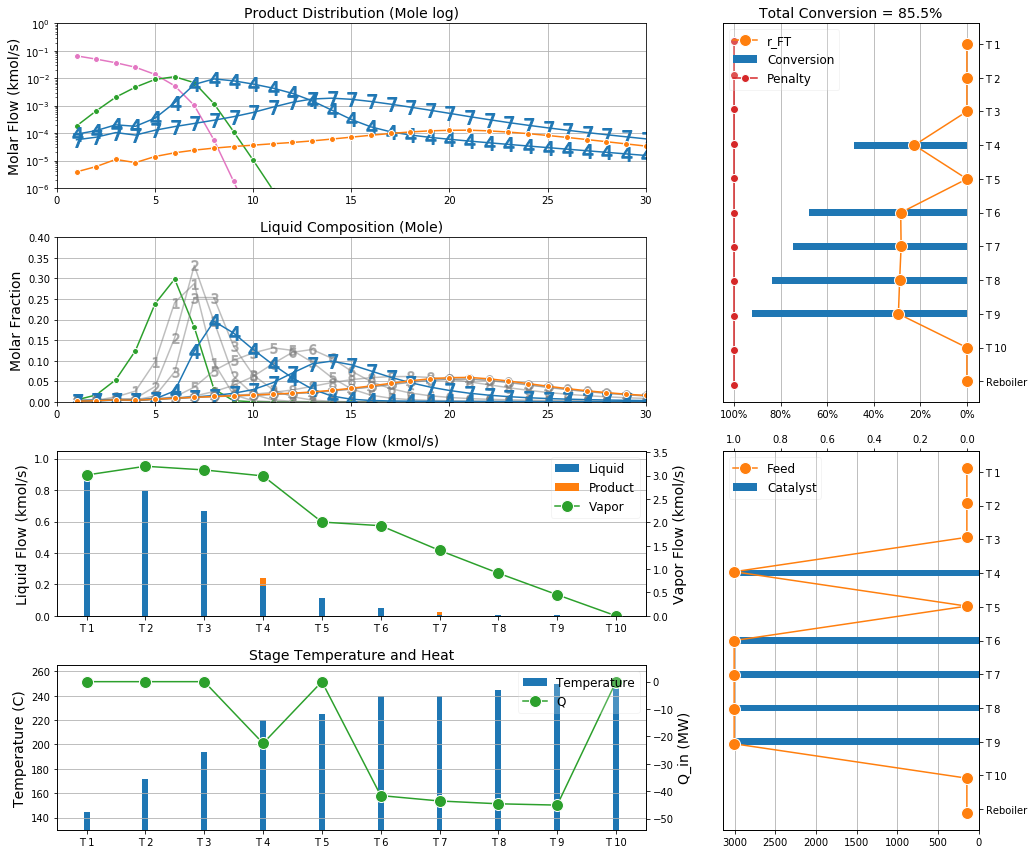

In [13]:
plot_distribution(model)